In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"7fbe15d9a5f46cd8acd85e530c00302c"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset

%cd dog_dataset

/content/dog_dataset


In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           6957         10  0.1764706        


In [6]:
!kaggle datasets download -d catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 681M/691M [00:06<00:00, 208MB/s]
100% 691M/691M [00:06<00:00, 114MB/s]
/content


In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv


Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from tqdm import tqdm
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense


In [9]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [11]:
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog',
               'afghan_hound','entlebucher', 'bernese_mountain_dog' ]
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


In [12]:
X_data = np.zeros((len(labels), 224,224, 3), dtype = "float32")

Y_data = label_binarize(labels["breed"], classes = CLASS_NAMES)

for i in tqdm(range(len(labels))):

  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i],
                       target_size= (224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis =0)
  X_data[i] = x/255.0

print("\nTrain Images Shape:", X_data.shape,
      'size: {:,}'.format(X_data.size))
print('One hot encoded output shape:',
      Y_data.shape, 'size: {:,}'.format(Y_data.size))



100%|██████████| 588/588 [00:01<00:00, 461.21it/s]


Train Images Shape: (588, 224, 224, 3) size: 88,510,464
One hot encoded output shape: (588, 5) size: 2,940


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

model = Sequential()

# First Conv Layer
model.add(Conv2D(filters=64, kernel_size=(5,5),
                 activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Second Conv Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# Third Conv Layer
model.add(Conv2D(filters=16, kernel_size=(7,7),
                 activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# Fourth Conv Layer
model.add(Conv2D(filters=8, kernel_size=(5,5),
                 activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 108, 108, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 16)          │          25,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,749 (635.74 KB)

 Trainable params: 162,749 (635.74 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.0001),
    metrics=['accuracy']
)

In [14]:
# Splitting the dataset into training and testing datasets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(
    X_data, Y_data, test_size = 0.1)

# Splitting the training dataset into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_and_val, Y_train_and_val, test_size = 0.2)

In [44]:
epochs = 100
batch_size = 32

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,               # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]  # Add early stopping callback here
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.1885 - loss: 5.3943 - val_accuracy: 0.2453 - val_loss: 5.3167
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2324 - loss: 5.2780 - val_accuracy: 0.3019 - val_loss: 5.2071
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2921 - loss: 5.1574 - val_accuracy: 0.3302 - val_loss: 5.0942
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2842 - loss: 5.0398 - val_accuracy: 0.3302 - val_loss: 4.9925
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3349 - loss: 4.9225 - val_accuracy: 0.3679 - val_loss: 4.8674
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3712 - loss: 4.8084 - val_accuracy: 0.3679 - val_loss: 4.7674
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3417 - loss: 4.7068 - val_accuracy: 0.3491 - val_loss: 4.6735
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3419 - loss: 4.6639 - val_accuracy: 

# Testing and Evaluation

In [45]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.4283 - loss: 3.8001
Test loss: 3.7776176929473877
Test accuracy: 0.4237288236618042


In [46]:
CLASS_NAMES

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog']

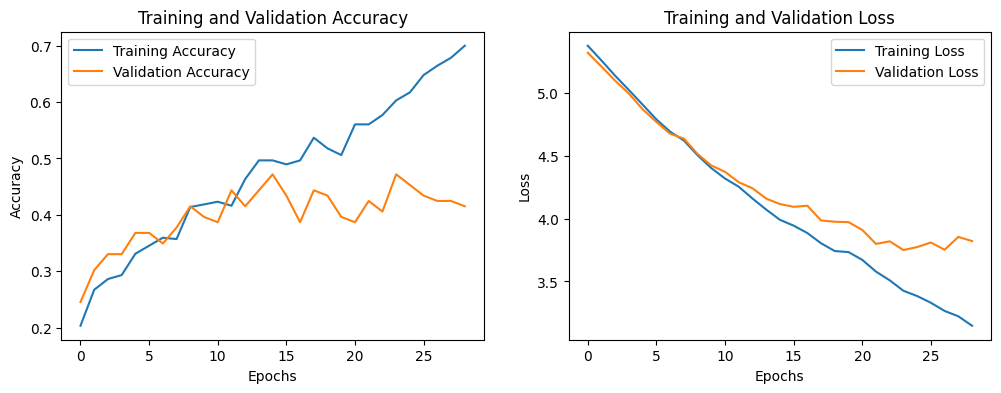

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = CLASS_NAMES

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Classification Report:
                       precision    recall  f1-score   support

  scottish_deerhound       0.40      0.50      0.44        20
         maltese_dog       0.68      0.60      0.64        25
        afghan_hound       0.38      0.46      0.42        24
         entlebucher       0.23      0.21      0.22        14
bernese_mountain_dog       0.65      0.48      0.55        23

            accuracy                           0.47       106
           macro avg       0.47      0.45      0.45       106
        weighted avg       0.49      0.47      0.48       106

Precision: 0.4930, Recall: 0.4717, F1 Score: 0.4771


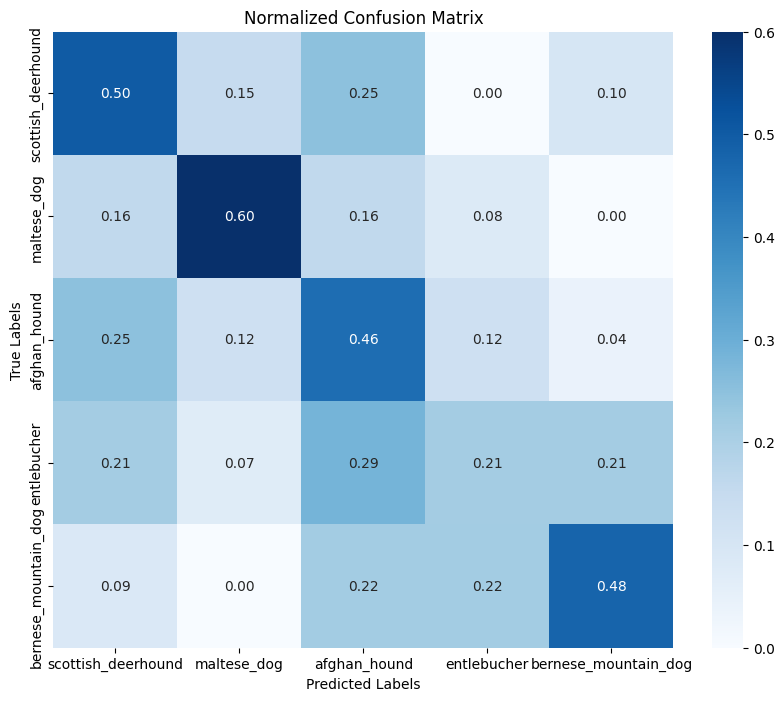

In [48]:
# Predict on validation data
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES))

# Precision, Recall, F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Normalized Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [49]:
model.save('dog_breed.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


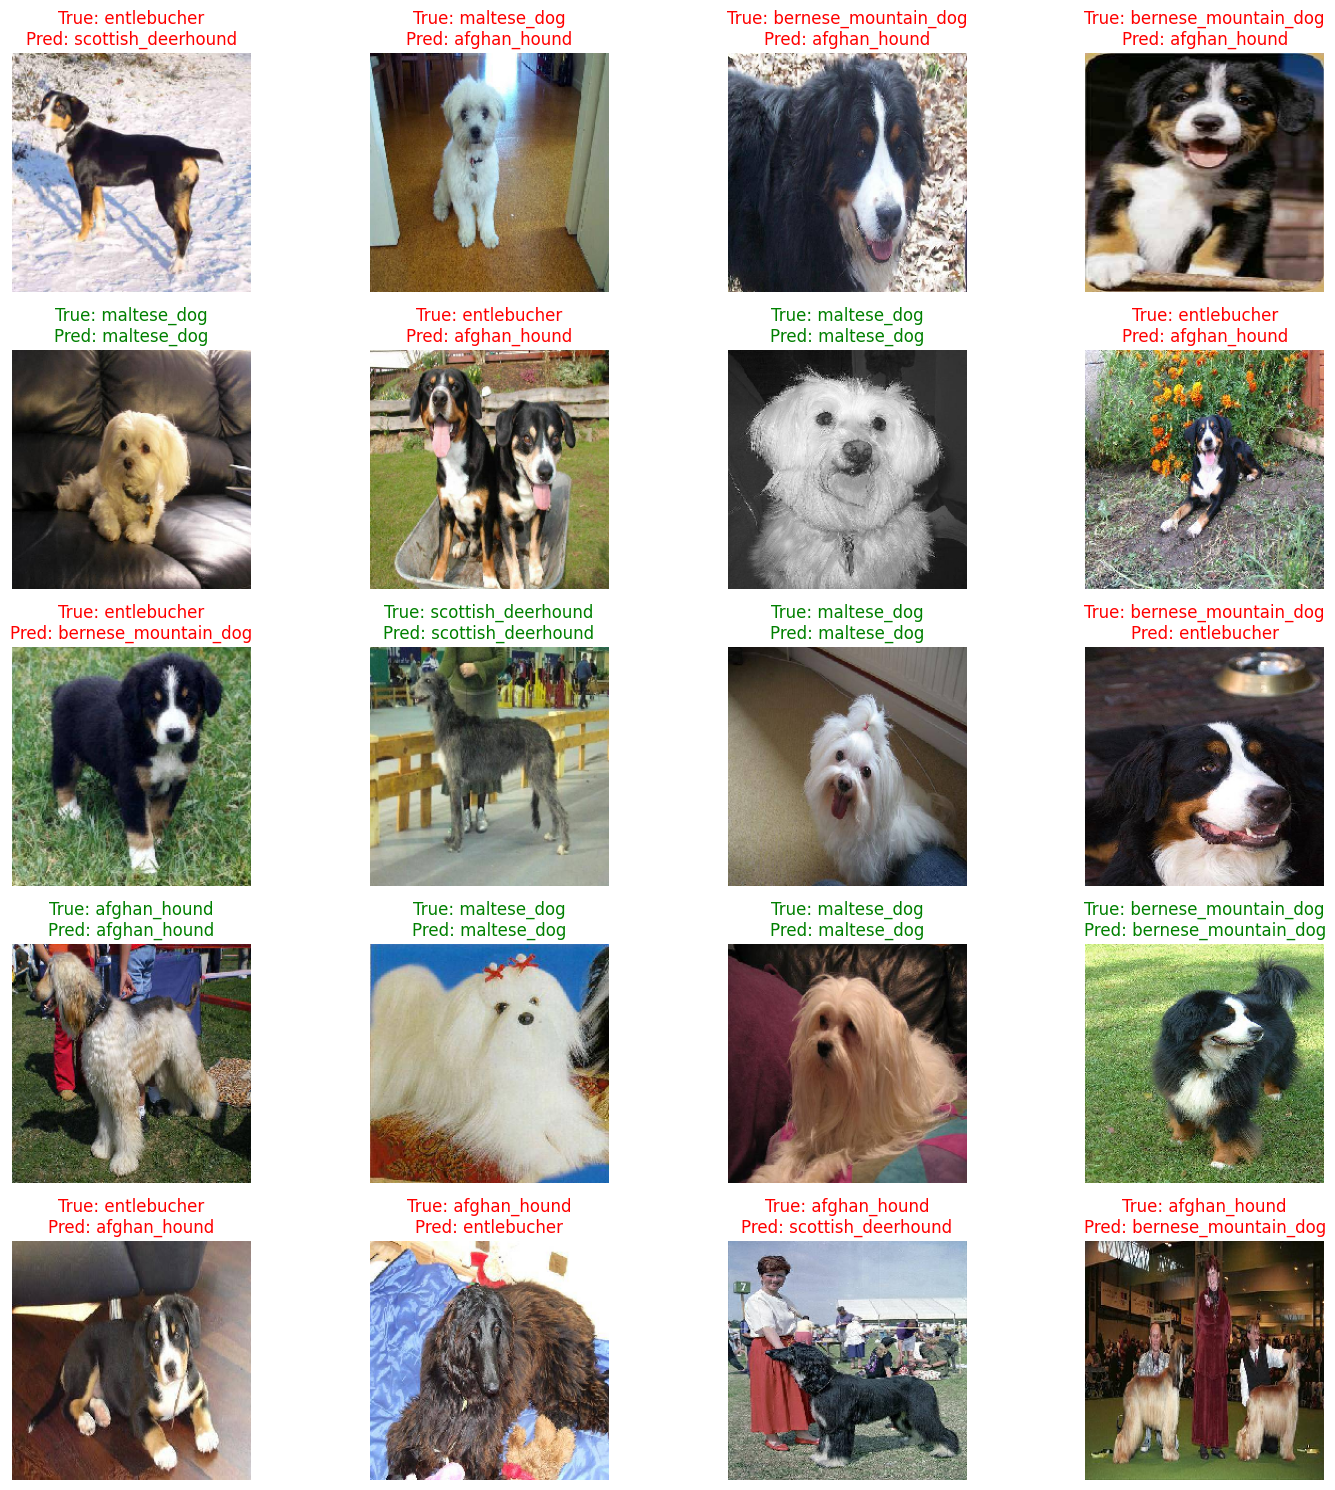

In [50]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 20  # Change this to display more or fewer images

# Predict on test data
Y_test_pred = model.predict(X_test)
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)
Y_test_true_classes = np.argmax(Y_test, axis=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)  # Adjust grid size for more images (e.g., 5x4 grid for 20 images)
    plt.imshow(X_test[i])  # Display the image
    plt.axis('off')

    # Set the title with true and predicted labels
    true_label = CLASS_NAMES[Y_test_true_classes[i]]
    pred_label = CLASS_NAMES[Y_test_pred_classes[i]]
    color = 'green' if true_label == pred_label else 'red'  # Green if correct, red if incorrect

    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)

plt.tight_layout()
plt.show()


# GUI Implementation

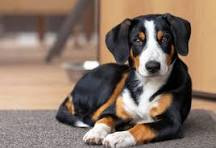

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [51]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = CLASS_NAMES  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = CLASS_NAMES[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))


In [52]:
CLASS_NAMES

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog']